# Assignment 1 - Q2 - Quantile Regression

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# inline plot
%matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
%config Completer.use_jedi = False

first, read the .parquet file using pyarrow and then convert to a pandas DataFrame

In [2]:
import pyarrow.parquet as pq
from pathlib import Path

data_path = Path('..') / 'data' / 'data2.parquet'  # assume there is a data folder in the parent path
data = pq.read_table(data_path, memory_map=True)
data = data.to_pandas()

analyze the data by sampling and visually in a scatter plot. look for outliers.

In [3]:
data.sample(5)

,x,y
83,8.383838,11.760237
53,5.353535,14.619921
70,7.070707,14.993713
45,4.545455,10.276796
44,4.444444,8.197357


<AxesSubplot:title={'center':'data scattter plot with outliers'}, xlabel='x', ylabel='y'>

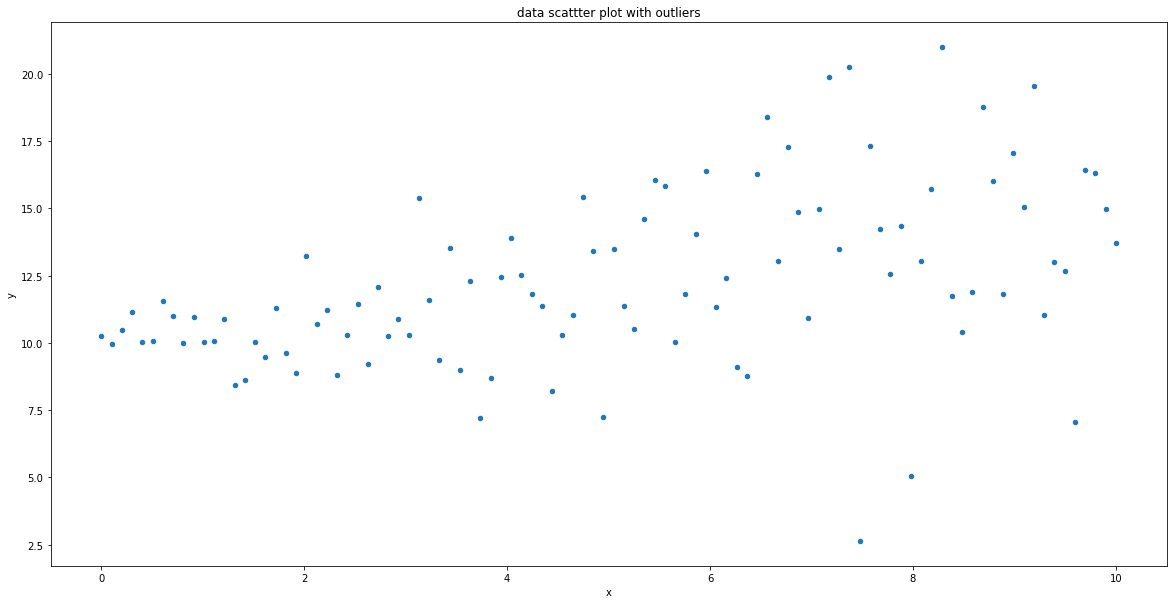

In [4]:
data.plot.scatter('x', 'y', title='data scattter plot with outliers')

we notice that the variance on the response variable y increases with x, and this is something linear regression won't be able to model,
as it only models the conditional mean of y on x.

now, try and fit a simple linear regressor

In [5]:
from sklearn.linear_model import LinearRegression
# include intercept
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(data.x.values.reshape(-1, 1), data.y)
f'y = {lin_reg.intercept_} + {lin_reg.coef_[0]} * x'

'y = 9.675209482951814 + 0.5143767923082178 * x'

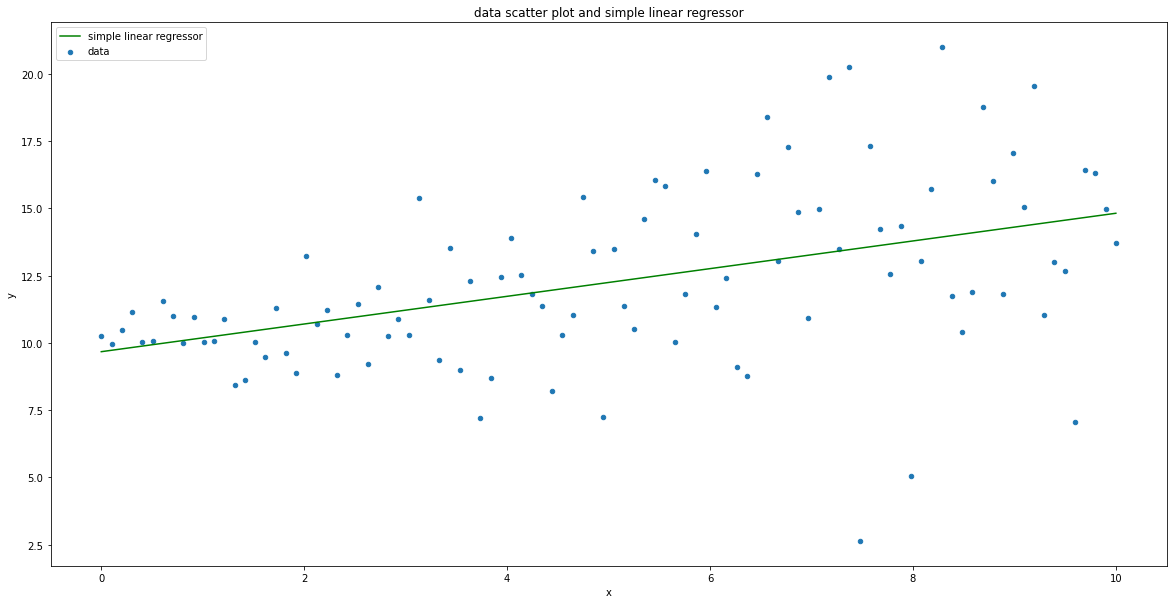

In [6]:
data.plot.scatter('x', 'y', title='data scatter plot and simple linear regressor', label='data')

plt.plot(data.x, lin_reg.predict(data.x.values.reshape(-1, 1)), "g-", label='simple linear regressor')
plt.legend(loc='upper left')
plt.show()

are the assumptions of linear regression correct? let's check it out.

Text(0.5, 1.0, 'Residuals vs. Fitted')

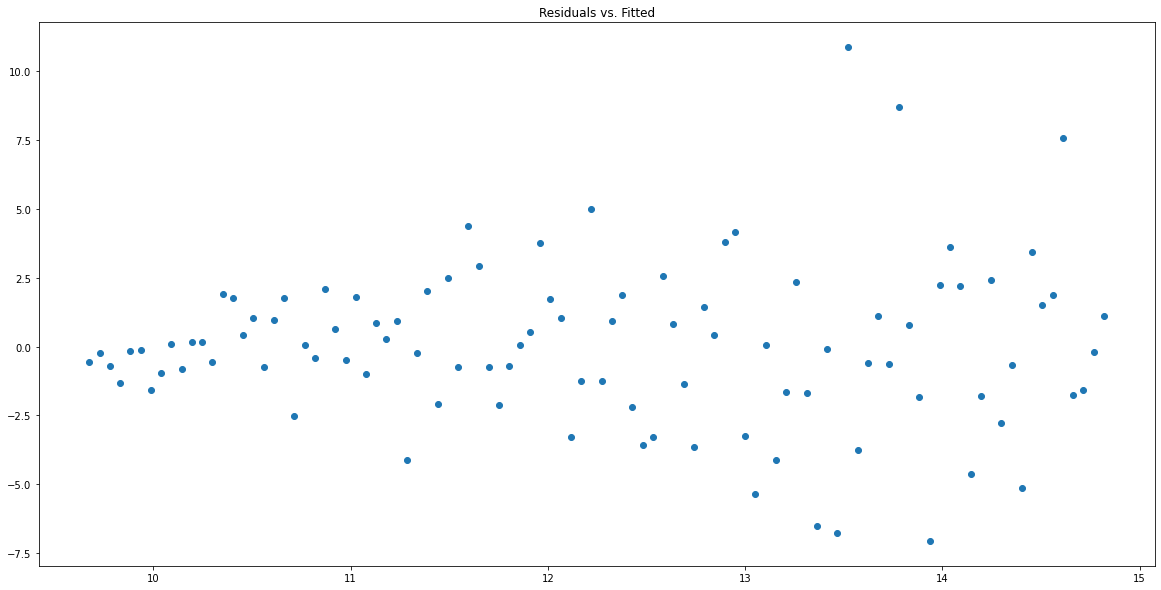

In [7]:
residuals = lin_reg.predict(data.x.values.reshape(-1, 1)) - data.y
plt.scatter(x=lin_reg.predict(data.x.values.reshape(-1, 1)), y=residuals)
plt.title('Residuals vs. Fitted')

there's an obvious pattern of a funnel shape, we consider this as a sign of non constant variance, i.e., heteroskedasticity.

perform a Shapiro-Wilks test to determine if the residuals are normally distributed

In [8]:
from scipy.stats import shapiro

shapiro(residuals)

ShapiroResult(statistic=0.9594196081161499, pvalue=0.0036565251648426056)

from the output we can see that the test statistic is 0.9594 and the corresponding p-value is 0.003, which is much lower than the usual cut-off p-value of 0.05. since the p-value is less than .05, we successfully reject the null hypothesis. we have sufficient evidence to say that the sample data does not come from a normal distribution.
meaning, the residuals do not seem normally distributed.

we conclude that the residuals do not meet linear regression key assumptions.

now about Quantile Regression:

Quantile regression is an extension of standard linear regression, which estimates the conditional median of the outcome variable and can be used if the assumptions of linear regression do not hold true.
Although quantile regression is most often used to model specific conditional quantiles of the response, its full potential
lies in modeling the entire conditional distribution. By comparison, standard linear regression models only the
conditional mean of the response and is computationally less expensive. Quantile regression does not assume a
particular parametric distribution for the response, nor does it assume a constant variance for the response, unlike
linear regression.
Meaning, linear regression for a response $Y$ and a predictor $X$ models the conditional mean $E[Y | X]$, but it does not
capture the conditional variance $Var[Y | X]$, much less the conditional distribution of Y given X.

By fitting a series of regression models for a grid of values of $\tau$ in the interval (0,1), you can describe the entire
conditional distribution of the response. The optimal grid choice depends on the data, and the more data you have,
the more detail you can capture in the conditional distribution.

The main advantages of quantile regression are:
1. Predicts conditional quantiles instead of just the conditional mean.
2. Unlike linear regression, it is distribution agnostic (no normality assumption).
3. It is robust to response outliers.

let's compare linear and quantile regression on our data:

In [9]:
from statsmodels.formula.api import quantreg, ols

# simple linear regression with least squares
ols_model = ols('y ~ x', data).fit()
confidence_interval = ols_model.conf_int().loc['x'].tolist()
ols_params = {'intercept': ols_model.params['Intercept'], 'slope': ols_model.params['x'], 'conf_int': confidence_interval}

In [10]:
quantiles = [0.05, 0.5, 0.95]
# fit a quantile regression model for each quantile
qreg = quantreg('y ~ x', data)
quantreg_models = [qreg.fit(q) for q in quantiles]
confidence_intervals = [quantreg_model.conf_int().loc['x'].tolist() for quantreg_model in quantreg_models]
quantreg_params = [{'intercept': quantreg_model.params['Intercept'], 'slope': quantreg_model.params['x'], 'conf_int': confidence_interval} for quantreg_model, confidence_interval in zip(quantreg_models, confidence_intervals)]

plot 1: we compare standard linear regression estimate with quantile regression estimates, per each quantile.

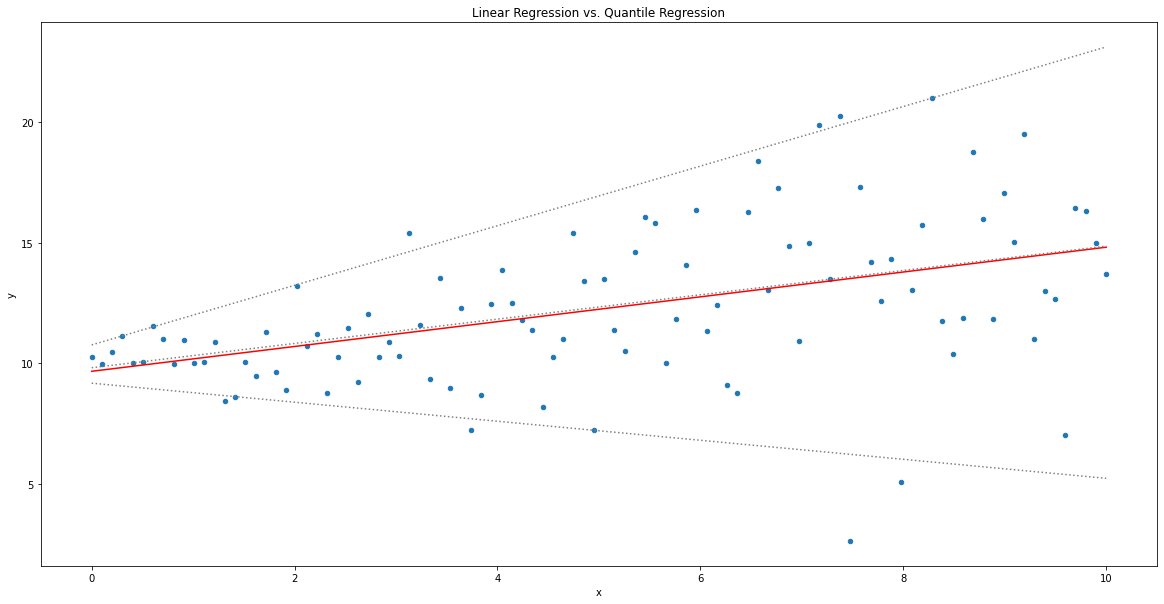

In [11]:
data.plot.scatter('x', 'y')

x = np.linspace(int(data.x.min()), int(data.x.max()), 200).reshape(-1, 1)
# linear regression line
y_linear = lin_reg.predict(x)
plt.plot(x, y_linear, "r-", label='Linear Regression')

for q, q_params in zip(quantiles, quantreg_params):
    plt.plot(x, q_params['intercept'] + q_params['slope'] * x, linestyle='dotted', color='grey')

plt.title('Linear Regression vs. Quantile Regression')
plt.show()

note the negative slope for lower quantiles and positive slope for higher quantiles. also, the mean estimator (standard linear regression) and the median estimator (quantile = 0.5) are close.

plot 2: we plot the slope at different quantiles with confidence intervals. note that the slope of linear regression is constant (by definition) and is presented for reference as well.

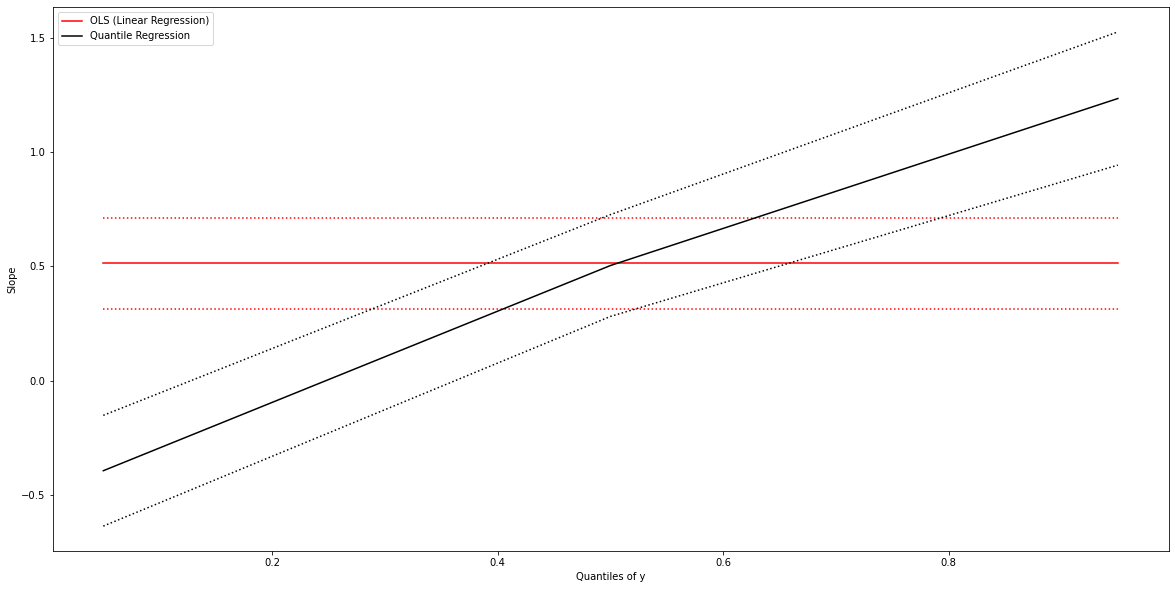

In [12]:
plt.plot(quantiles, [ols_params['slope'] for _ in quantiles], color="red", label="OLS (Linear Regression)")
plt.plot(quantiles, [ols_params['conf_int'][0] for _ in quantiles], linestyle="dotted", color="red")
plt.plot(quantiles, [ols_params['conf_int'][1] for _ in quantiles], linestyle="dotted", color="red")

plt.plot(quantiles, [q_params['slope'] for q_params in quantreg_params], color="black", label="Quantile Regression")
plt.plot(quantiles, [q_params['conf_int'][0] for q_params in quantreg_params], color="black", linestyle="dotted")
plt.plot(quantiles, [q_params['conf_int'][1] for q_params in quantreg_params], color="black", linestyle="dotted")

plt.ylabel(r"Slope")
plt.xlabel("Quantiles of y")
plt.legend()
plt.show()

we see that for low and for high quantiles, the quantile regression slopes are far outside of the linear regression confidence intervals.
this probably indicates a non-constant connection between x and y variables, across the distribution of y.